In [1]:
library(tidyverse)
library(cowplot)
library(glue)
library(igraph)
library(ggnetwork)

rslt <- '../results/'

gwas <- read_tsv('~/projects/waffles/results/main_effects/plink.assoc.logistic', col_types = 'icdccdddd') %>%
    filter(TEST == 'ADD') %>%
    rename(chr = CHR, snp = SNP, pos = BP) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

make_key <- function(a1, a2) {
    cbind(a1, a2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_')
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked 

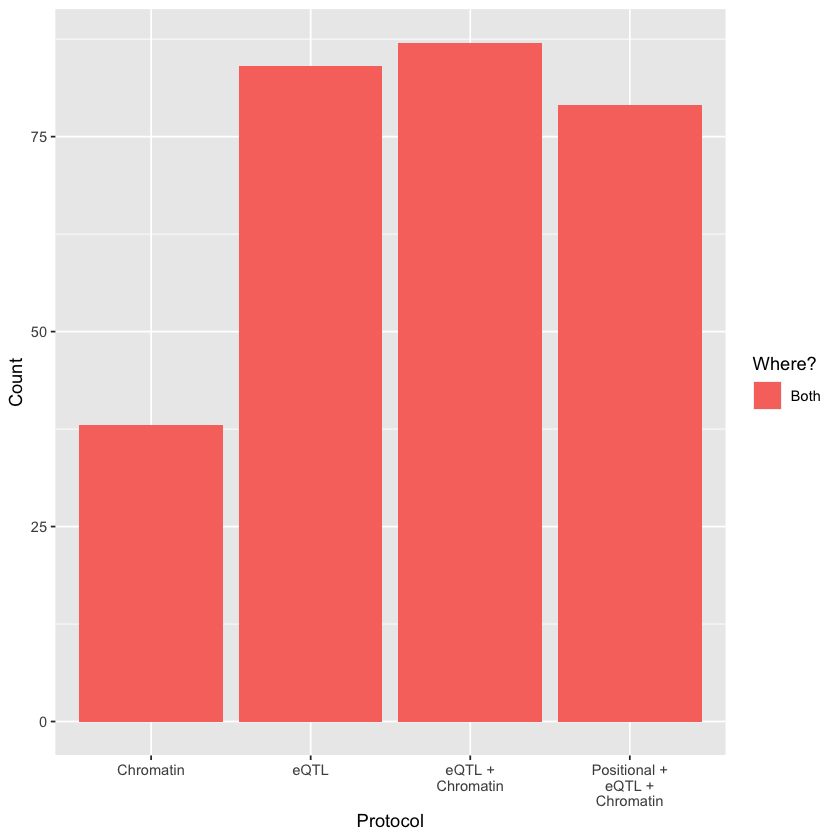

In [2]:
read_files <- function(tag, where) {
    before <- read_csv(glue('{rslt}/withBiofilter_filter/{tag}/sign_SNPpairs.txt'), col_types = 'ccdccc')
    after <- read_csv(glue('{rslt}/withBiofilter_filter/{tag}/sign_SNPpairs_add.txt'), col_types = 'ccd')

    full_join(before, after, by = c('SNP_1' = 'SNP1', 'SNP_2' = 'SNP2')) %>%
        mutate(new = ifelse(is.na(pvalue_uncorrected_MT), 'Only new', 'Only old'),
               new = ifelse(!is.na(PRS_adj_pval) & !is.na(pvalue_uncorrected_MT), 'Both', new),
               where = where)
}

pvals <- bind_rows(read_files('chromatin', 'Chromatin'),
                   read_files('eqtl', 'eQTL'),
                   read_files('eqtl_chrom', 'eQTL +\nChromatin'),
                   read_files('eqtl_chrom_phys', 'Positional +\neQTL +\nChromatin'))

pvals %>%
    ggplot(aes(x = where, fill = new)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Count', fill = 'Where?')

## Main effects influence on epistasis detection

In [3]:
mh_plot <- function(protocol, tag) {

    gwais <- read_csv(glue('{rslt}/withBiofilter_filter/{protocol}/sign_SNPpairs.txt'), col_types = 'ccdccc')
    epi_snps <- c(gwais$SNP_1, gwais$SNP_2) %>% unique

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate(BPcum = pos + tot,
             epi_snp = snp %in% epi_snps)

    bf_threshold <- .05 / (nrow(gwas))
    y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
    n_main <- filter(gwas, selected == 'Yes') %>% nrow
    n_epi <- length(epi_snps)

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +
        geom_point(data = filter(don, epi_snp), color='#2b2e4a', size=1.3) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12),
          strip.text.y = element_text(size = 15),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'), 
             title = tag)
    
    }

mh_plt <- plot_grid(mh_plot('eqtl', 'eQTL'), mh_plot('chromatin', 'Chromatin'),
                    mh_plot('eqtl_chrom', 'eQTL + Chromatin'), mh_plot('eqtl_chrom_phys', 'Positional + eQTL + Chromatin'))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [4]:
pval_plt <- pvals %>%
    mutate(where = factor(where, levels = c('eQTL', 'Chromatin', 'eQTL +\nChromatin', 'Positional +\neQTL +\nChromatin'))) %>%
    ggplot(aes(x = -log10(PRS_adj_pval), y = -log10(pvalue_uncorrected_MT))) +
        geom_point() +
        geom_abline(slope = 1) +
        facet_wrap(. ~ where, nrow = 1) +
        labs(x = bquote('-log' [10]~'(PRS-adjusted P-value)'),
             y = bquote('-log' [10]~'(P-value)')) +
        theme_bw() +
        theme(text = element_text(size = 18))

In [5]:
get_mapped_genes <- function(genes, snps) {

    uniq_snp2gene <- read_csv(paste0(rslt, genes), col_types = 'cdccd') %>%
        separate_rows(SNP1, sep = ' ') %>%
        separate_rows(SNP2, sep = ' ') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = make_key(gene1, gene2),
               uniq_snp_id = make_key(SNP1, SNP2),
               sign_gene = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, sign_gene) %>%
        unique

    uniq_snp <- read_csv(paste0(rslt, snps), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = make_key(SNP_1, SNP_2),
               uniq_gene_id = make_key(gene1, gene2),
               sign_snp = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, sign_snp) %>%
        unique
    
    full_join(uniq_snp, uniq_snp2gene, by = c("uniq_gene_id", "uniq_snp_id")) %>%
        mutate(sign_gene = ifelse(is.na(sign_gene), FALSE, TRUE),
               sign_snp = ifelse(is.na(sign_snp), FALSE, TRUE))
    
}

strenghtened_pairs <- filter(pvals, PRS_adj_pval < pvalue_uncorrected_MT) %>%
    select(SNP_1, SNP_2) %>%
    unique %>%
    inner_join(gwas, by = c('SNP_1' = 'snp')) %>%
    inner_join(gwas, by = c('SNP_2' = 'snp'), suffix = c('_1', '_2')) %>%
    select(SNP_1, SNP_2, chr_1, chr_2) %>%
    mutate(uniq_snp_id = make_key(SNP_1, SNP_2)) %>%
    select(uniq_snp_id, chr_1, chr_2) %>%
    unique

strenghtened_gene <- bind_rows(get_mapped_genes('noFilter/sign_GenePairs.txt', 'noFilter/sign_SNPPairs.txt') %>% mutate(exp = 'Standard'),
          get_mapped_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/chromatin/sign_SNPPairs.txt') %>% mutate(exp = 'Chromatin'),
          get_mapped_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/eqtl/sign_SNPPairs.txt') %>% mutate(exp = 'eQTL'),
          get_mapped_genes('withBiofilter_filter/eqtl_chrom/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/eqtl_chrom/sign_SNPPairs.txt') %>% mutate(exp = 'eQTL + Chromatin'),
          get_mapped_genes('withBiofilter_filter/eqtl_chrom_phys/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/eqtl_chrom_phys/sign_SNPPairs.txt') %>% mutate(exp = 'Positional + eQTL + Chromatin')) %>%
    select(uniq_gene_id, uniq_snp_id) %>%
    inner_join(strenghtened_pairs, by = "uniq_snp_id") %>%
    unique

ibd_genes <- read_tsv('../data/C0021390_disease_gda_summary.tsv',
                      col_types = cols(.default = col_character()))$Gene

str_snps_plt <- strenghtened_gene %>%
    select(-uniq_gene_id) %>%
    separate(uniq_snp_id, into = c('snp_1', 'snp_2'), sep = '_') %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray50', size = 3) +
        geom_nodes(size = 10, color = '#3490de') +
        geom_nodetext_repel(aes(label = name), size = 5.5) +
        theme_blank() +
        theme(legend.position = 'none') +
        theme(plot.title = element_text(size = 23, face = "bold")) +
        theme_transparent +
        scale_size_manual(values = c('TRUE' = 13, 'FALSE' = 8)) +
        scale_shape_manual(values = c('TRUE' = 18, 'FALSE' = 16))

str_genes_plt <- strenghtened_gene %>%
    separate(uniq_gene_id, into = c('gene_1', 'gene_2'), sep = '_') %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    mutate(ibd = name %in% ibd_genes) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray50', size = 3) +
        geom_nodes(aes(size = ibd, shape = ibd), color = '#3f72af') +
        geom_nodetext_repel(aes(label = name), size = 5.5) +
        theme_blank() +
        theme(legend.position = 'none') +
        theme(plot.title = element_text(size = 23, face = "bold")) +
        theme_transparent +
        scale_size_manual(values = c('TRUE' = 13, 'FALSE' = 8)) +
        scale_shape_manual(values = c('TRUE' = 18, 'FALSE' = 16))

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


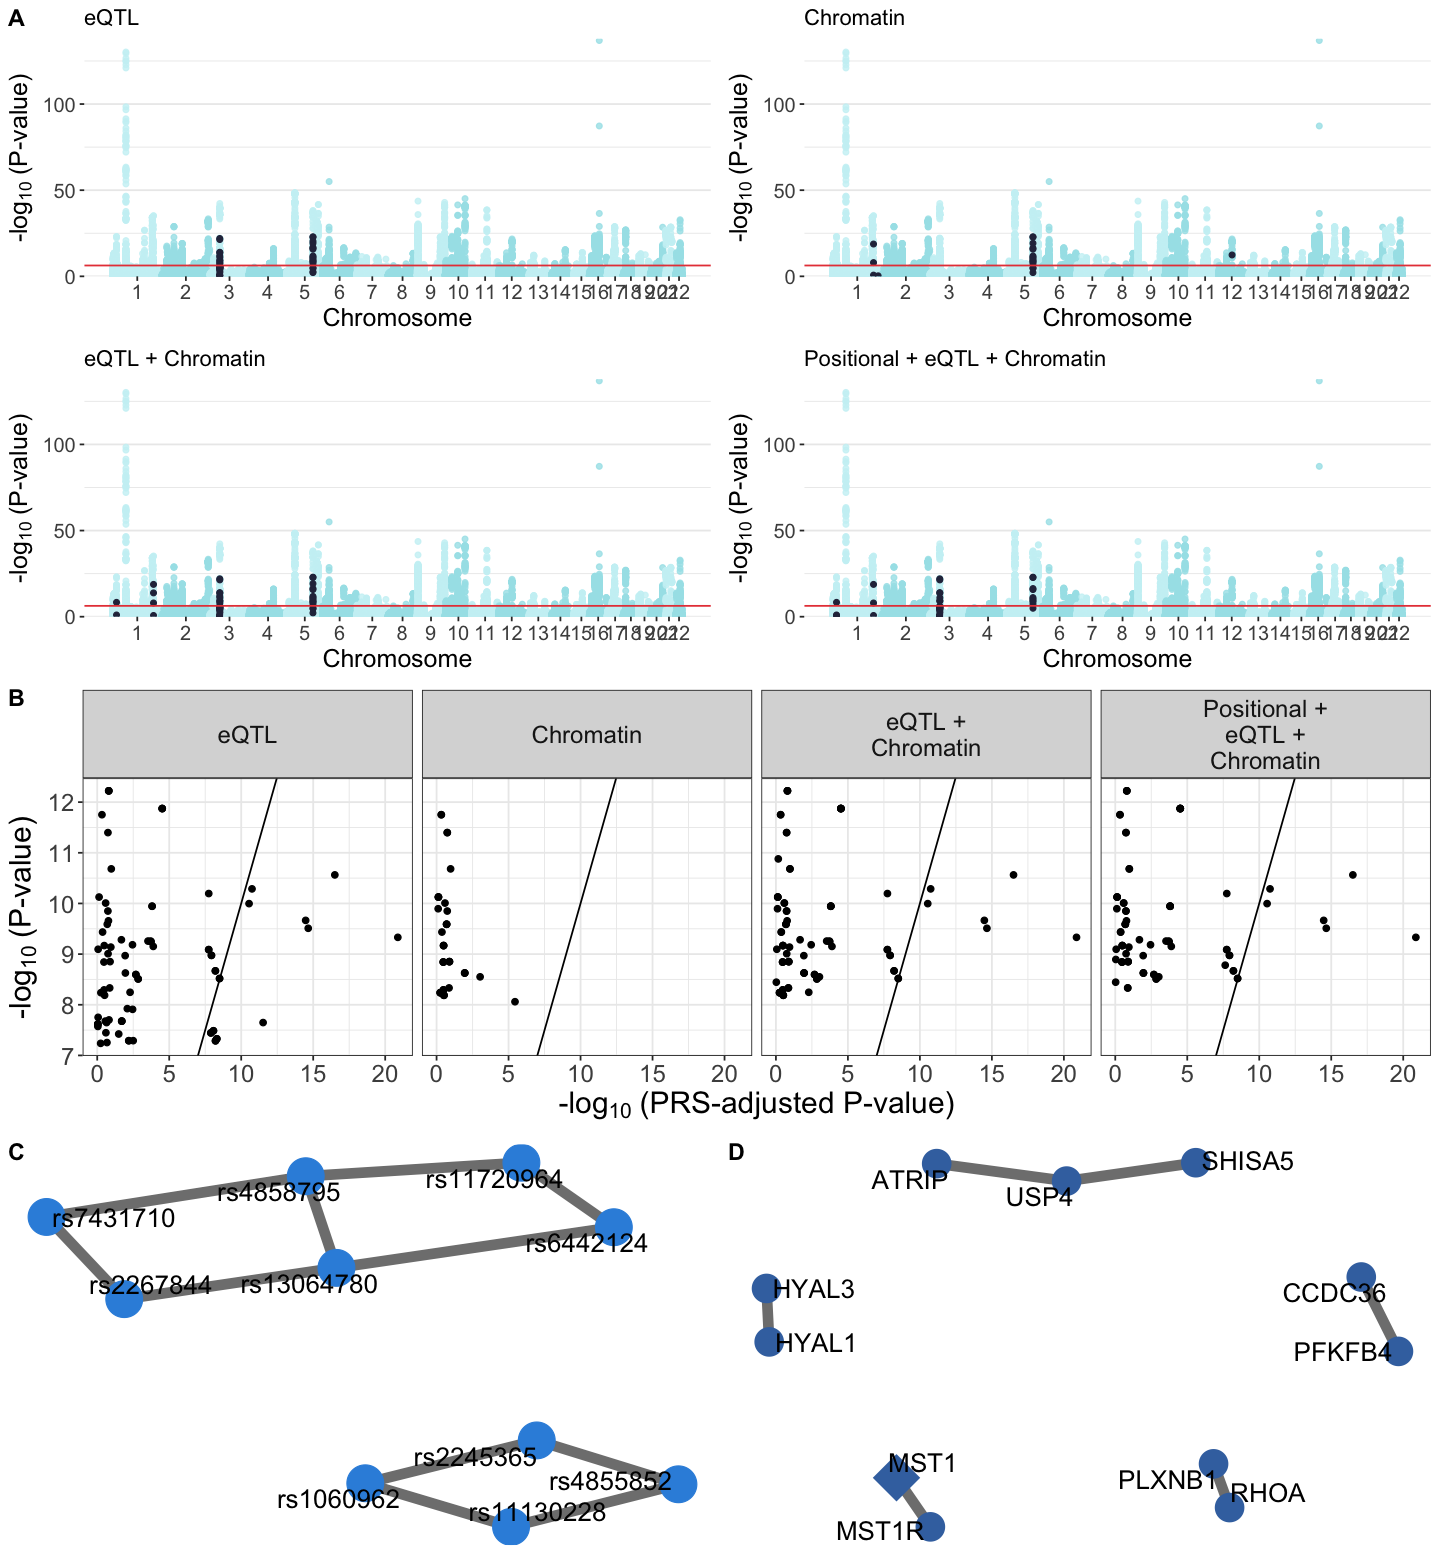

In [6]:
options(repr.plot.width=12, repr.plot.height=13)
plot_grid(plot_grid(mh_plt, pval_plt, nrow = 2, labels = c('A','B'), rel_heights = c(1.5, 1)),
          plot_grid(str_snps_plt, str_genes_plt, ncol = 2, labels = c('C','D')), 
          nrow = 2, rel_heights = c(2,.75))
ggsave('fig/prs_adjusted_vs_unadjusted.png', width=12, height=13)

In [7]:
# unique SNPs in Pairs strengthened by PRS-adjustment
c(filter(pvals, PRS_adj_pval < pvalue_uncorrected_MT)$SNP_1,
  filter(pvals, PRS_adj_pval < pvalue_uncorrected_MT)$SNP_2) %>%
    unique

[1] "rs11130228" "rs2245365"  "rs2267844"  "rs4855852"  "rs4858795" 
 [6] "rs6442124"  "rs7431710"  "rs1060962"  "rs13064780" "rs11720964"